In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
def get_volt():
    """Measure voltage."""
    v = np.random.normal(0, 2)   # v: measurement noise.
    volt_true = 14.4             # volt_true: True voltage [V].
    z_volt_meas = volt_true + v  # z_volt_meas: Measured Voltage [V] (observable).
    return z_volt_meas

In [3]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable.
       Return Kalman Gain for Drawing.
    """
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P, K

In [4]:
# Input parameters.
time_end = 10
dt = 0.2

In [5]:
# Initialization for system model.
A = 1
H = 1
Q = 0
R = 4
# Initialization for estimation.
x_0 = 12  # 14 for book.
P_0 = 6
K_0 = 1

In [6]:
time = np.arange(0, time_end, dt)
n_samples = len(time)
volt_meas_save = np.zeros(n_samples)
volt_esti_save = np.zeros(n_samples)
P_save = np.zeros(n_samples)
K_save = np.zeros(n_samples)

In [7]:
x_esti, P, K = None, None, None
for i in range(n_samples):
    z_meas = get_volt()
    if i == 0:
        x_esti, P, K = x_0, P_0, K_0
    else:
        x_esti, P, K = kalman_filter(z_meas, x_esti, P)

    volt_meas_save[i] = z_meas
    volt_esti_save[i] = x_esti
    P_save[i] = P
    K_save[i] = K

Text(0, 0.5, 'Kalman Gain (K)')

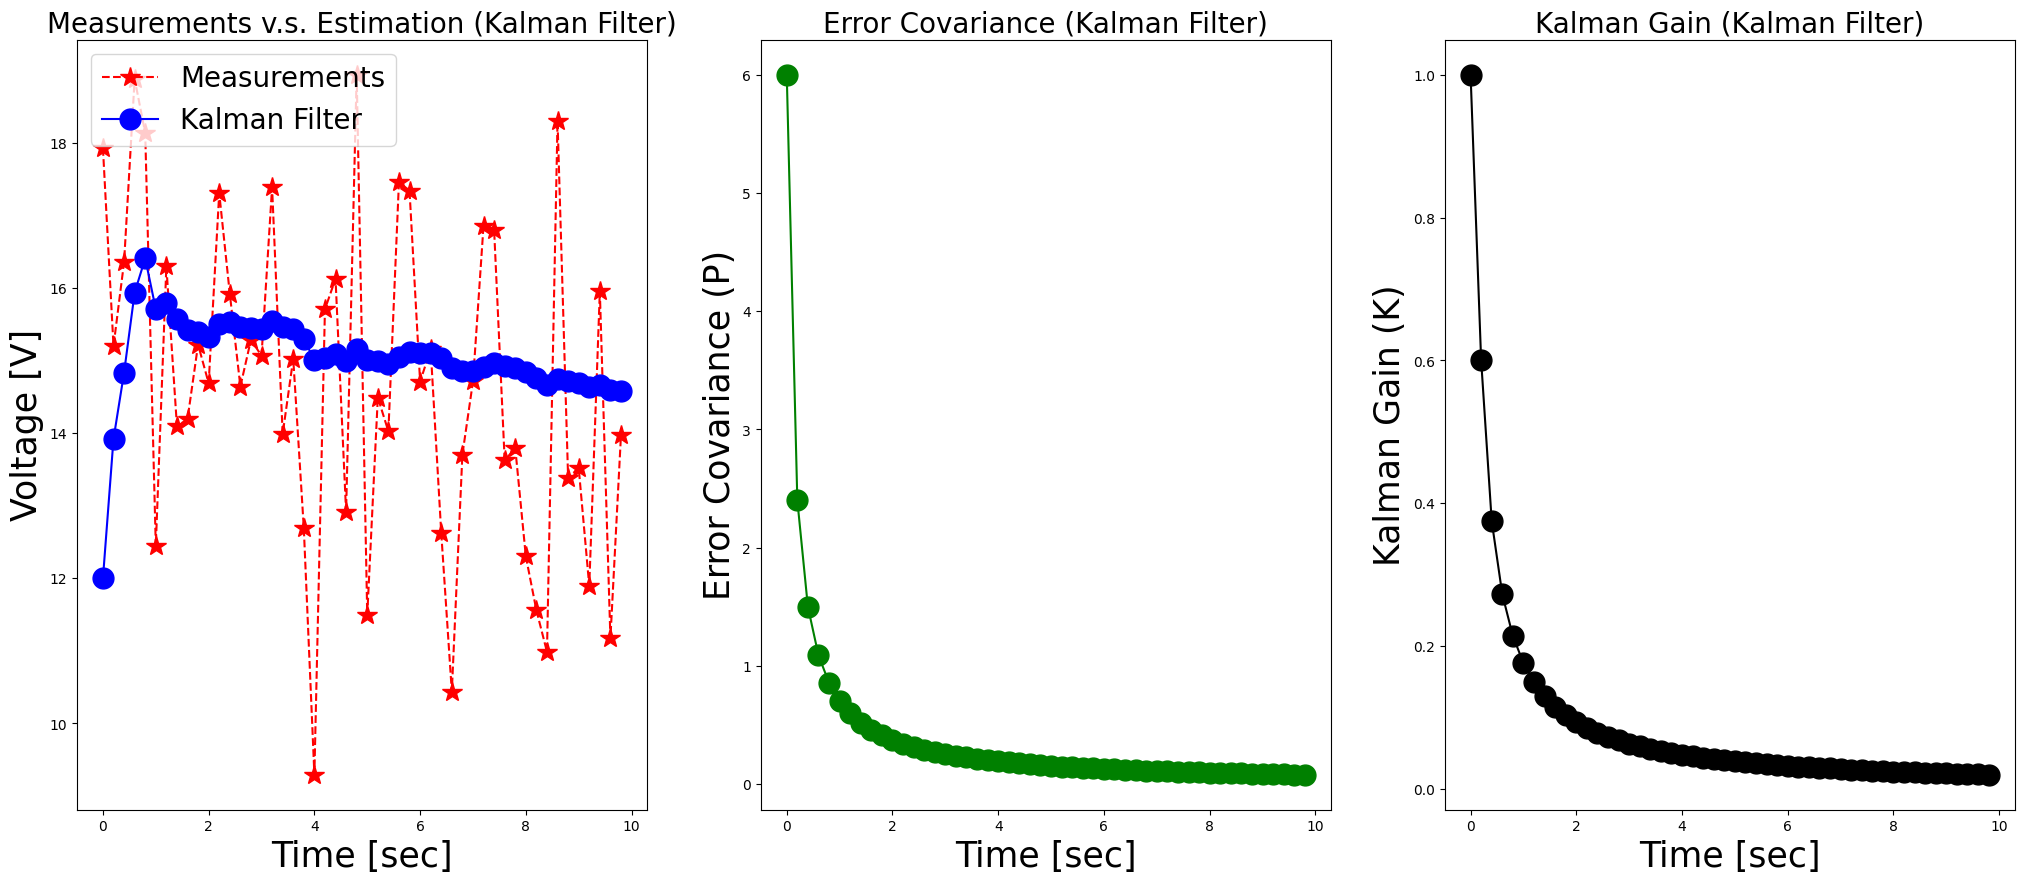

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))

plt.subplot(1, 3, 1)
plt.plot(time, volt_meas_save, 'r*--', label='Measurements', markersize=15)
plt.plot(time, volt_esti_save, 'bo-', label='Kalman Filter', markersize=15)
plt.legend(loc='upper left', fontsize=20)
plt.title('Measurements v.s. Estimation (Kalman Filter)', fontsize=20)
plt.xlabel('Time [sec]', fontsize=25)
plt.ylabel('Voltage [V]', fontsize=25)

plt.subplot(1, 3, 2)
plt.plot(time, P_save, 'go-', markersize=15)
plt.title('Error Covariance (Kalman Filter)', fontsize=20)
plt.xlabel('Time [sec]', fontsize=25)
plt.ylabel('Error Covariance (P)', fontsize=25)

plt.subplot(1, 3, 3)
plt.plot(time, K_save, 'ko-', markersize=15)
plt.title('Kalman Gain (Kalman Filter)', fontsize=20)
plt.xlabel('Time [sec]', fontsize=25)
plt.ylabel('Kalman Gain (K)', fontsize=25)
#plt.savefig('png/simple_kalman_filter2.png')

## FilterPy 구현

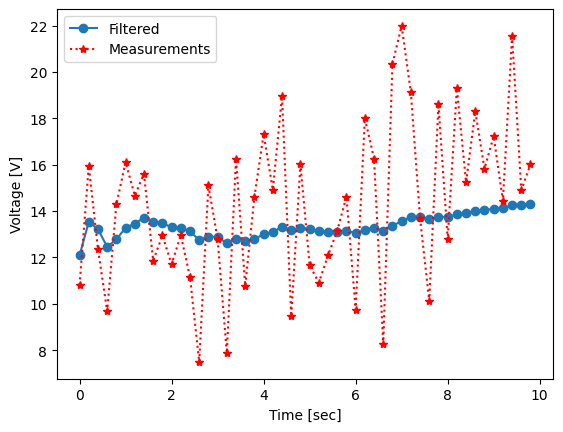

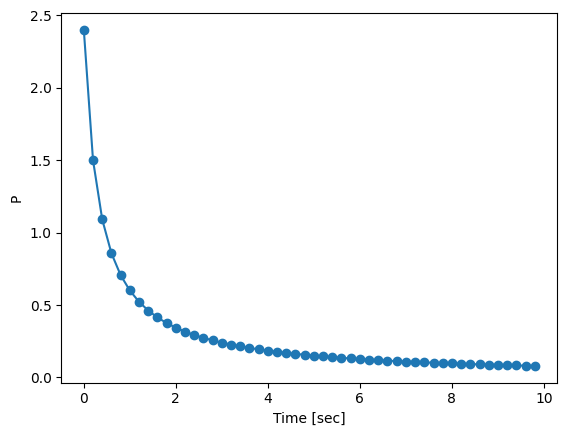

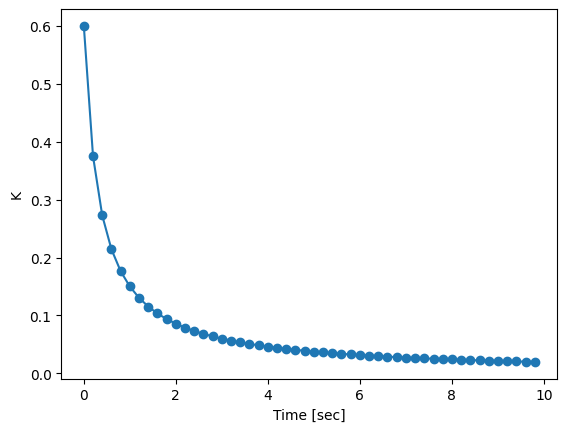

In [11]:
! pip install filterpy

import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

# 랜덤 노이즈를 포함한 측정값 생성
def get_volt():
    return 14.4 + np.random.normal(0, 4)

# 칼만 필터 초기화
kf = KalmanFilter(dim_x=1, dim_z=1)
kf.F = np.array([[1]])  # 상태 전이 행렬
kf.H = np.array([[1]])  # 관측 행렬
kf.Q = np.array([[0]])  # 프로세스 잡음 공분산
kf.R = np.array([[4]])  # 측정 잡음 공분산
kf.P = np.array([[6]])  # 초기 공분산
kf.x = np.array([[14]]) # 초기 상태

# 칼만 필터 적용
def filterpy_kalman(z):
    kf.predict()
    kf.update(z)
    return kf.x[0, 0], kf.P[0, 0], kf.K[0, 0]

# 테스트
t = np.arange(0, 10, 0.2)
Xsaved = []
Zsaved = []
for _ in t:
    z = get_volt()
    filtered, cov, gain = filterpy_kalman(z)
    Xsaved.append([filtered, cov, gain])
    Zsaved.append(z)

Xsaved = np.array(Xsaved)

# 시각화
plt.figure()
plt.plot(t, Xsaved[:, 0], 'o-', label="Filtered")
plt.plot(t, Zsaved, 'r:*', label="Measurements")
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')
plt.legend()

plt.figure()
plt.plot(t, Xsaved[:, 1], 'o-', label="Covariance (P)")
plt.xlabel('Time [sec]')
plt.ylabel('P')

plt.figure()
plt.plot(t, Xsaved[:, 2], 'o-', label="Kalman Gain (K)")
plt.xlabel('Time [sec]')
plt.ylabel('K')
plt.show()

##PyKalman 구현

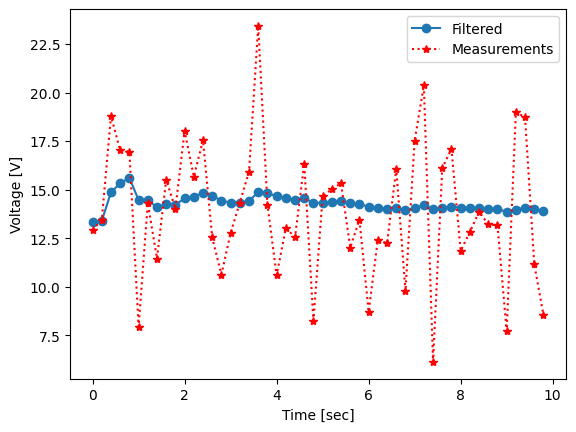

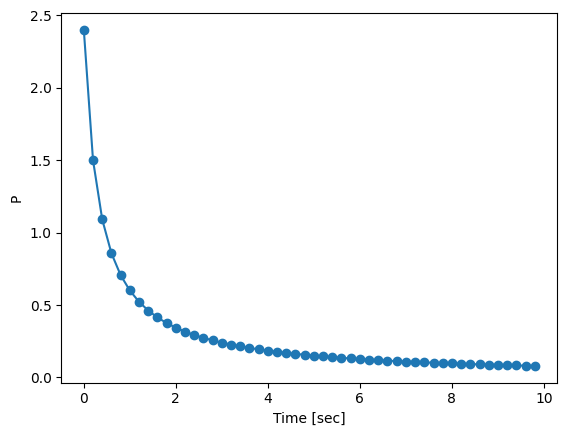

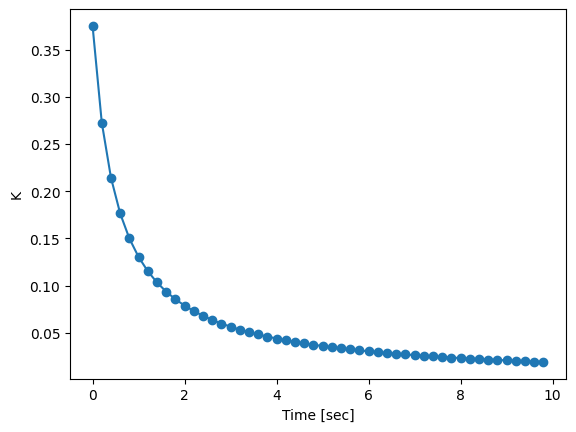

In [15]:
! pip install pykalman

from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt

# 랜덤 노이즈를 포함한 측정값 생성
def get_volt():
    return 14.4 + np.random.normal(0, 4)

# 칼만 필터 초기화
kf = KalmanFilter(initial_state_mean=14, initial_state_covariance=6,
                  transition_matrices=[1], observation_matrices=[1],
                  transition_covariance=[[0]], observation_covariance=[[4]])

# 테스트
t = np.arange(0, 10, 0.2)
Xsaved = []
Zsaved = []
for _ in t:
    z = get_volt()
    state_mean, state_covariance = kf.filter_update(kf.initial_state_mean,
                                                    kf.initial_state_covariance,
                                                    observation=z)
    kalman_gain = state_covariance[0, 0] / (state_covariance[0, 0] + 4)  # R = 4
    Xsaved.append([state_mean[0], state_covariance[0, 0], kalman_gain])
    Zsaved.append(z)
    kf.initial_state_mean = state_mean
    kf.initial_state_covariance = state_covariance

# Convert Xsaved to a numpy array after ensuring its elements are consistent
Xsaved = np.array(Xsaved, dtype=object)

# 시각화
plt.figure()
plt.plot(t, Xsaved[:, 0].astype(float), 'o-', label="Filtered")
plt.plot(t, Zsaved, 'r:*', label="Measurements")
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')
plt.legend()

plt.figure()
plt.plot(t, Xsaved[:, 1].astype(float), 'o-', label="Covariance (P)")
plt.xlabel('Time [sec]')
plt.ylabel('P')

plt.figure()
plt.plot(t, Xsaved[:, 2].astype(float), 'o-', label="Kalman Gain (K)")
plt.xlabel('Time [sec]')
plt.ylabel('K')
plt.show()


##OpenCV 구현

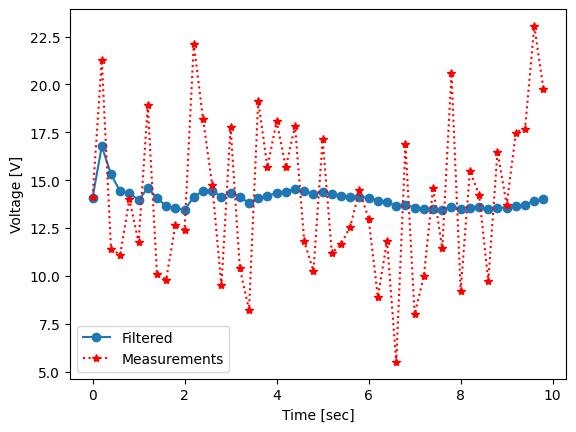

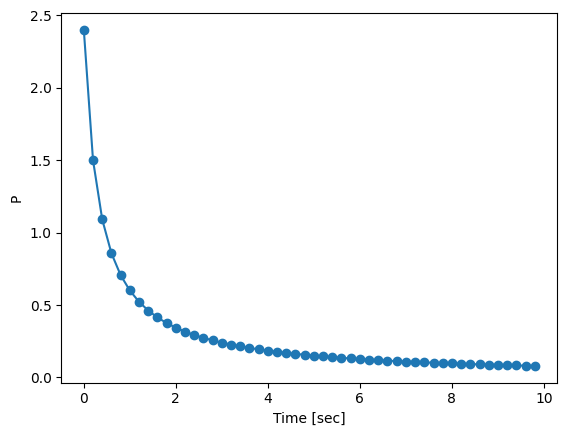

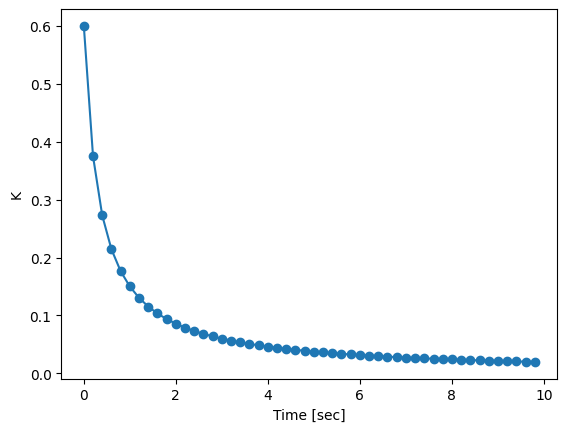

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 랜덤 노이즈를 포함한 측정값 생성
def get_volt():
    return 14.4 + np.random.normal(0, 4)

# 칼만 필터 초기화
kf = cv2.KalmanFilter(1, 1)
kf.measurementMatrix = np.array([[1]], np.float32)
kf.transitionMatrix = np.array([[1]], np.float32)
kf.processNoiseCov = np.array([[0]], np.float32)
kf.measurementNoiseCov = np.array([[4]], np.float32)
kf.errorCovPost = np.array([[6]], np.float32)
kf.statePost = np.array([[14]], np.float32)

# 테스트
t = np.arange(0, 10, 0.2)
Xsaved = []
Zsaved = []
for _ in t:
    z = get_volt()
    kf.predict()
    kf.correct(np.array([[z]], np.float32))
    filtered = kf.statePost[0, 0]
    cov = kf.errorCovPost[0, 0]
    gain = kf.gain[0, 0]
    Xsaved.append([filtered, cov, gain])
    Zsaved.append(z)

Xsaved = np.array(Xsaved)

# 시각화
plt.figure()
plt.plot(t, Xsaved[:, 0], 'o-', label="Filtered")
plt.plot(t, Zsaved, 'r:*', label="Measurements")
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')
plt.legend()

plt.figure()
plt.plot(t, Xsaved[:, 1], 'o-', label="Covariance (P)")
plt.xlabel('Time [sec]')
plt.ylabel('P')

plt.figure()
plt.plot(t, Xsaved[:, 2], 'o-', label="Kalman Gain (K)")
plt.xlabel('Time [sec]')
plt.ylabel('K')
plt.show()


##Python 기본 구현

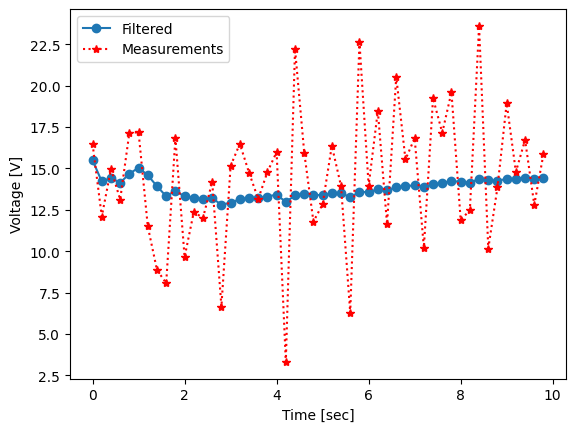

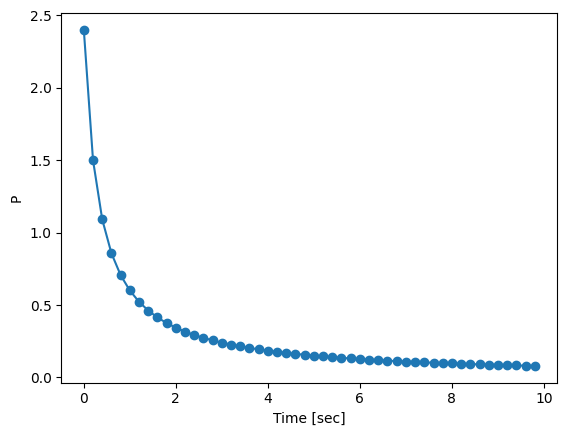

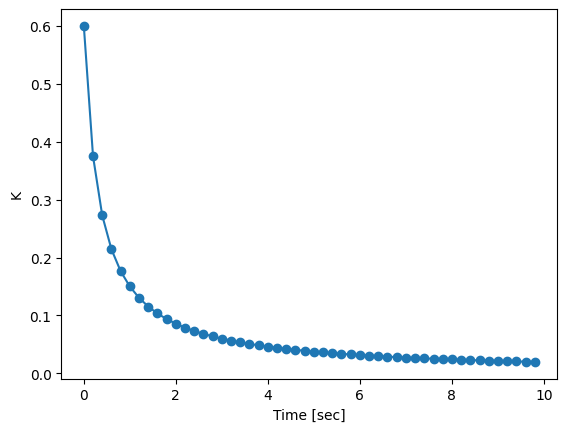

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 초기화
A = 1  # 상태 전이 행렬
H = 1  # 관측 행렬
Q = 0  # 프로세스 잡음 공분산
R = 4  # 측정 잡음 공분산
x = 14  # 초기 상태
P = 6   # 초기 공분산

# 랜덤 노이즈를 포함한 측정값 생성
def get_volt():
    return 14.4 + np.random.normal(0, 4)

# 칼만 필터 구현
def basic_kalman(z):
    global x, P
    # 예측 단계
    xp = A * x
    Pp = A * P * A + Q

    # 칼만 이득 계산
    K = Pp * H / (H * Pp * H + R)

    # 업데이트 단계
    x = xp + K * (z - H * xp)
    P = Pp - K * H * Pp

    return x, P, K

# 테스트
t = np.arange(0, 10, 0.2)
Xsaved = []
Zsaved = []

for _ in t:
    z = get_volt()
    filtered, cov, gain = basic_kalman(z)
    Xsaved.append([filtered, cov, gain])
    Zsaved.append(z)

Xsaved = np.array(Xsaved)

# 시각화
plt.figure()
plt.plot(t, Xsaved[:, 0], 'o-', label="Filtered")
plt.plot(t, Zsaved, 'r:*', label="Measurements")
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')
plt.legend()

plt.figure()
plt.plot(t, Xsaved[:, 1], 'o-', label="Covariance (P)")
plt.xlabel('Time [sec]')
plt.ylabel('P')

plt.figure()
plt.plot(t, Xsaved[:, 2], 'o-', label="Kalman Gain (K)")
plt.xlabel('Time [sec]')
plt.ylabel('K')
plt.show()
